# Análisis de Componentes Principales y Clustering  
## Dataset *Palmer Penguins*

**Máster en Minería de Datos**  
Alumno: Gerson Castillo  
DNI: 54786597T  
Profesor: Pablo Arcadio  
Fecha de elaboración: 18 de mayo de 2025  

---


## Fase A – Exploración inicial  
En esta fase cargaremos el dataset **Palmer Penguins**, inspeccionaremos sus primeras filas y revisaremos la estructura general (valores nulos, tipos de dato, estadísticas descriptivas).


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns, os, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from FuncionesMineria2 import plot_varianza_explicada, plot_corr_cos, plot_pca_scatter_with_vectors
import numpy as np
from sklearn.decomposition import PCA
from FuncionesMineria2 import (plot_varianza_explicada, plot_cos2_heatmap, plot_corr_cos, plot_cos2_bars,
                               plot_contribuciones_proporcionales, plot_pca_scatter, plot_pca_scatter_with_vectors,
                               plot_pca_scatter_with_categories)

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

# Cargar el dataset
df = sns.load_dataset("penguins")

# Vista rápida
df.head()



,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Las primeras filas muestran las variables morfológicas (*bill_length_mm*, *bill_depth_mm*, *flipper_length_mm*, *body_mass_g*) y factores categóricos (*species*, *island*, *sex*). Se aprecia la presencia de valores nulos en algunas columnas, lo que será tratado en los pasos siguientes.


### Estructura y descriptivos básicos  

Se examina la información general del DataFrame y las estadísticas descriptivas de las variables numéricas para detectar valores faltantes, rangos y posibles atípicos.


In [2]:
# Información general y estadísticos básicos
df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


,count,mean,std,min,25%,50%,75%,max
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0


La salida indica:

- **344 registros totales** y **7 columnas**.  
- Cuatro variables numéricas (`float64`) y tres categóricas (`object`).  
- Valores faltantes en todas las variables morfológicas (2 ausentes) y en *sex* (11 ausentes).



In [3]:
# Limpieza de datos
df_clean = df.dropna().reset_index(drop=True)
print(f"Filas originales: {len(df)} — Filas tras limpiar: {len(df_clean)}")



Filas originales: 344 — Filas tras limpiar: 333


Tras eliminar registros con valores faltantes se conservan **333 individuos**.  
Este criterio (*list-wise deletion*) simplifica el flujo analítico y afecta a menos del 4 % de la muestra.


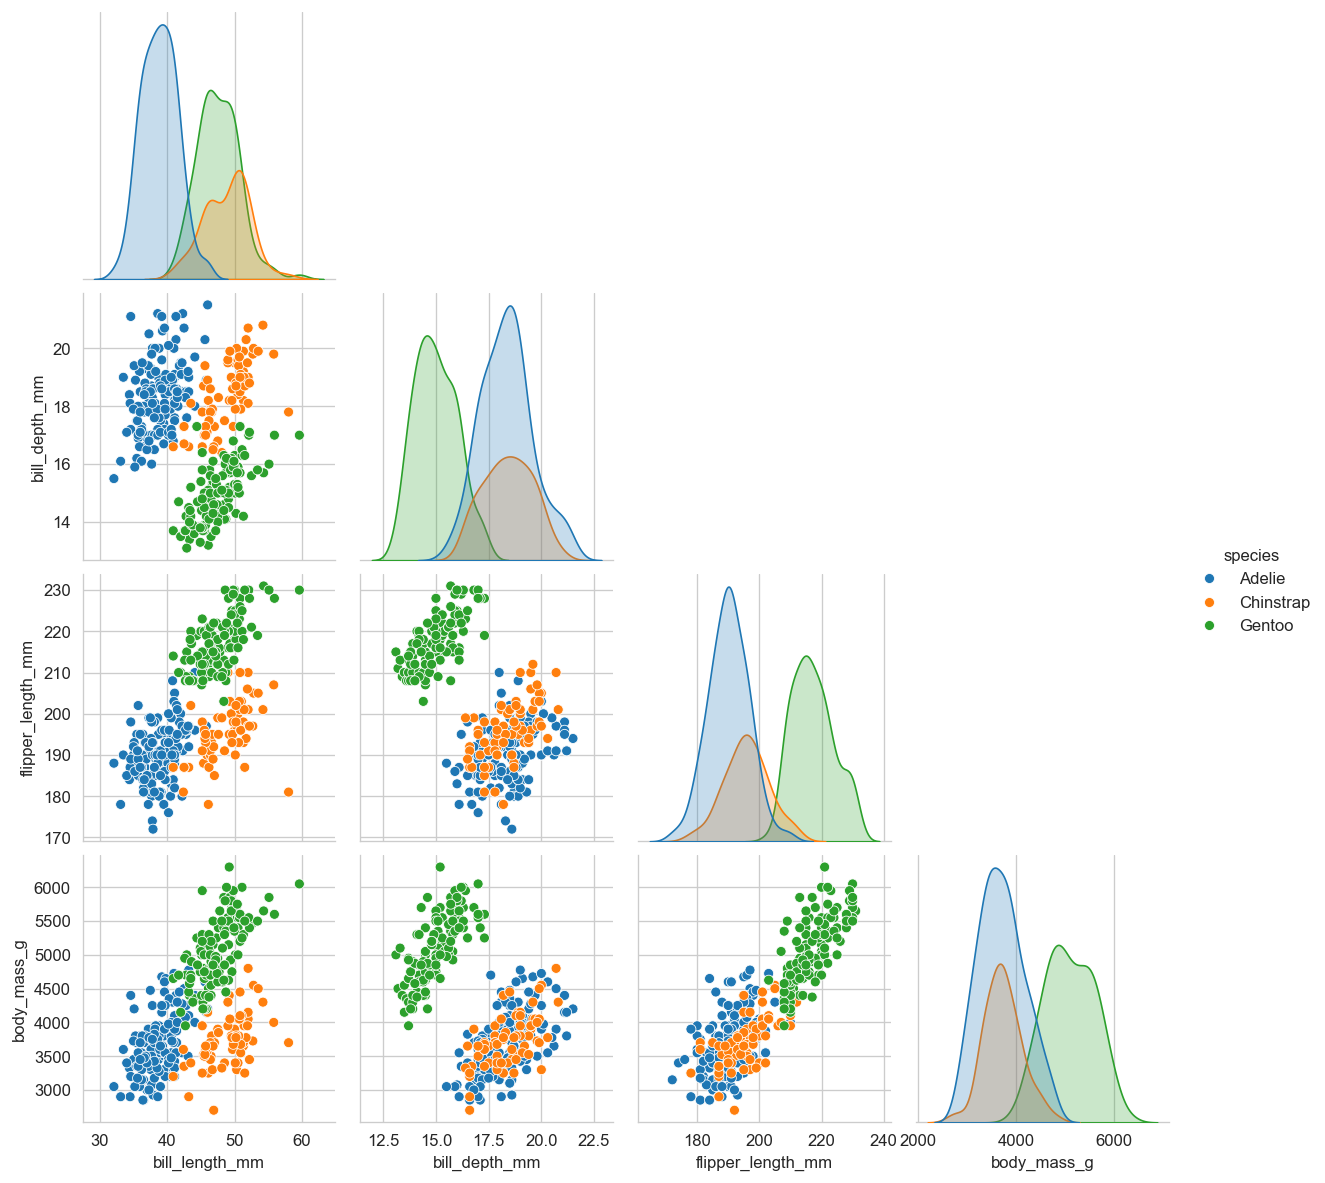

In [4]:
os.makedirs("fig", exist_ok=True)

pair = sns.pairplot(
    df_clean,
    hue="species",
    vars=["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"],
    corner=True
)
pair.savefig("fig/fig_00_pairplot.png", dpi=300)
plt.show()


El *pairplot* revela tres patrones destacados:

1. **Agrupación clara** de los *Gentoo* hacia valores altos de largo de pico, longitud de aleta y masa corporal.  
2. **Solapamiento moderado** entre *Adelie* y *Chinstrap*, especialmente en *bill_depth_mm*.  
3. **Relaciones lineales positivas** fuertes entre las variables de tamaño, justificando la aplicación de ACP para condensar la información redundante antes del clustering.



## Fase B – Análisis de correlaciones  

Se calcula la matriz de correlaciones entre las variables morfológicas para detectar dependencias lineales y justificar el uso de ACP.


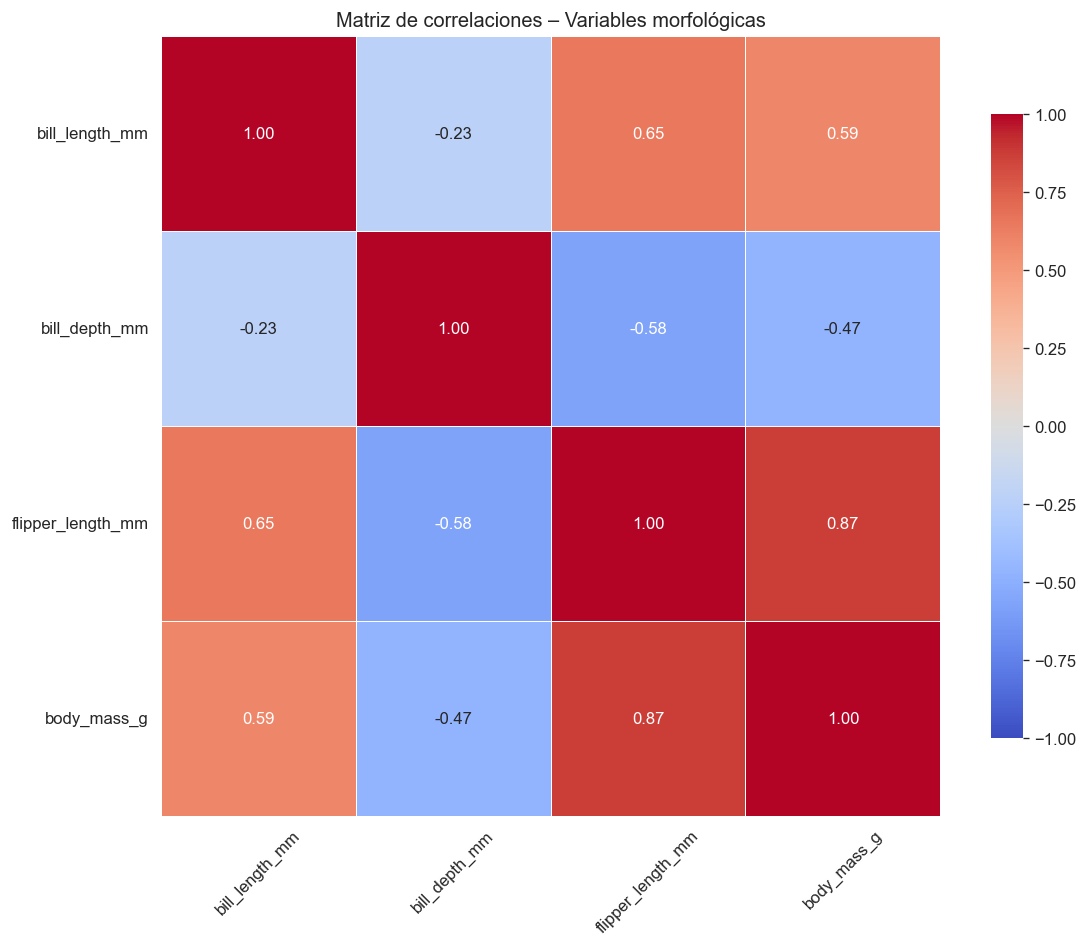

In [5]:
# Selección de variables numéricas
vars_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
corr = df_clean[vars_num].corr()

# Dibujo del heat-map
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    vmin=-1, vmax=1,
    cbar_kws={"shrink": .8}
)
plt.title("Matriz de correlaciones – Variables morfológicas")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Guardar la figura
plt.savefig("fig/fig_01_heatmap_corr.png", dpi=300)
plt.show()

**Interpretación de la matriz de correlaciones**  

- **bill_length_mm vs bill_depth_mm**: r = −0.23 (débil negativa)  
- **bill_length_mm vs flipper_length_mm**: r = 0.65 (moderada positiva)  
- **bill_length_mm vs body_mass_g**: r = 0.59 (moderada positiva)  
- **bill_depth_mm vs flipper_length_mm**: r = −0.58 (moderada negativa)  
- **bill_depth_mm vs body_mass_g**: r = −0.47 (moderada negativa)  
- **flipper_length_mm vs body_mass_g**: r = 0.87 (fuerte positiva)  

Estas relaciones evidencian redundancias entre las medidas de tamaño y justifican el uso de ACP para sintetizar la información y mitigar la multicolinealidad.


## Fase C – Variabilidad explicada por el ACP

Estandarización de las variables morfológicas, cálculo de un PCA completo y representación de la variabilidad explicada mediante scree plot.



              Autovalores  Variabilidad Explicada (%)  \
Componente 1     2.753625                   68.633893   
Componente 2     0.780461                   19.452929   
Componente 3     0.369753                    9.216063   
Componente 4     0.108210                    2.697115   

              Variabilidad Acumulada (%)  
Componente 1                   68.633893  
Componente 2                   88.086822  
Componente 3                   97.302885  
Componente 4                  100.000000  


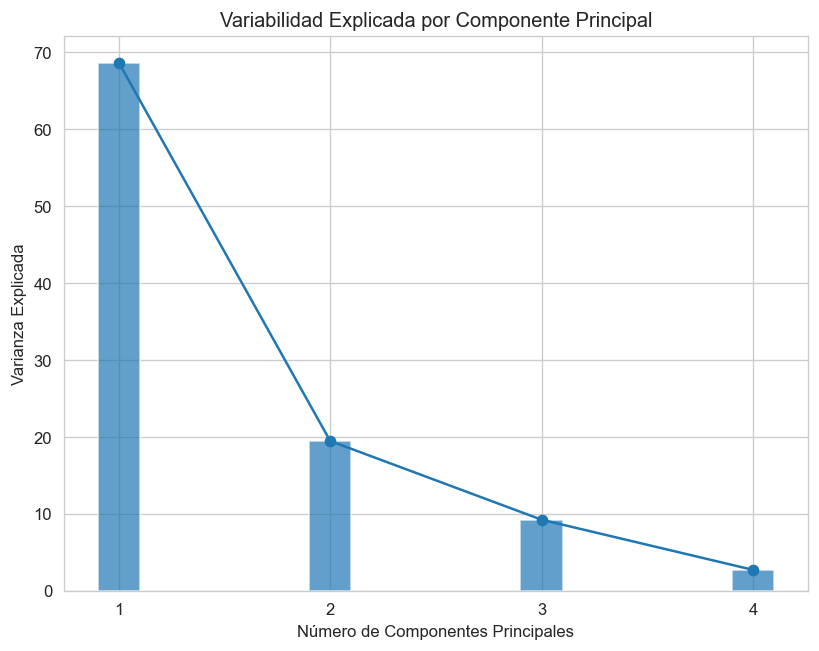

In [6]:
# 1. Variables numéricas
vars_num = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
notas = df_clean[vars_num]

# 2. Estandarización
notas_estandarizadas = pd.DataFrame(
    StandardScaler().fit_transform(notas),
    columns=[f"{col}_z" for col in vars_num],
    index=df_clean.index
)

# 3. PCA completo (todas las componentes)
pca_full = PCA(n_components=len(vars_num))
fit_full = pca_full.fit(notas_estandarizadas)

# 4. Autovalores y varianza explicada
autovalores    = fit_full.explained_variance_
var_explicada  = fit_full.explained_variance_ratio_ * 100
var_acumulada  = np.cumsum(var_explicada)


# 5. Tabla de resultados
tabla_pca = pd.DataFrame(
    {
        "Autovalores": autovalores,
        "Variabilidad Explicada (%)": var_explicada,
        "Variabilidad Acumulada (%)": var_acumulada
    },
    index=[f"Componente {i}" for i in range(1, fit_full.n_components_ + 1)]
)
print(tabla_pca)


# 6. Scree plot (función oficial)
plot_varianza_explicada(var_explicada, fit_full.n_components_)



## Fase D – Interpretación detallada de los Componentes Principales

A partir del ACP ejecutado en la Fase C, se procede a interpretar los dos primeros componentes principales. Estos ejes explican el 88,1 % de la variabilidad total y permiten una reducción dimensional sin pérdida sustancial de información. Se examinan a continuación:

- Las correlaciones entre las variables originales y las componentes.
- La calidad de la representación de las variables (cos²).
- La contribución proporcional de cada variable a los ejes.
- La distribución conjunta de individuos y variables en el plano factorial.



Cargas de las variables en PC1 y PC2:
                           PC1       PC2
bill_length_mm_z     0.453753  0.600195
bill_depth_mm_z     -0.399047  0.796170
flipper_length_mm_z  0.576825  0.005788
body_mass_g_z        0.549675  0.076464 

Medias de puntuación por especie:
                 PC1       PC2
species                      
Adelie    -1.459721 -0.141503
Chinstrap -0.388600  0.993365
Gentoo     2.012976 -0.394028 



,PC1,PC2
bill_length_mm_z,0.751829,0.529438
bill_depth_mm_z,-0.661186,0.702309
flipper_length_mm_z,0.955748,0.005106
body_mass_g_z,0.910762,0.067449


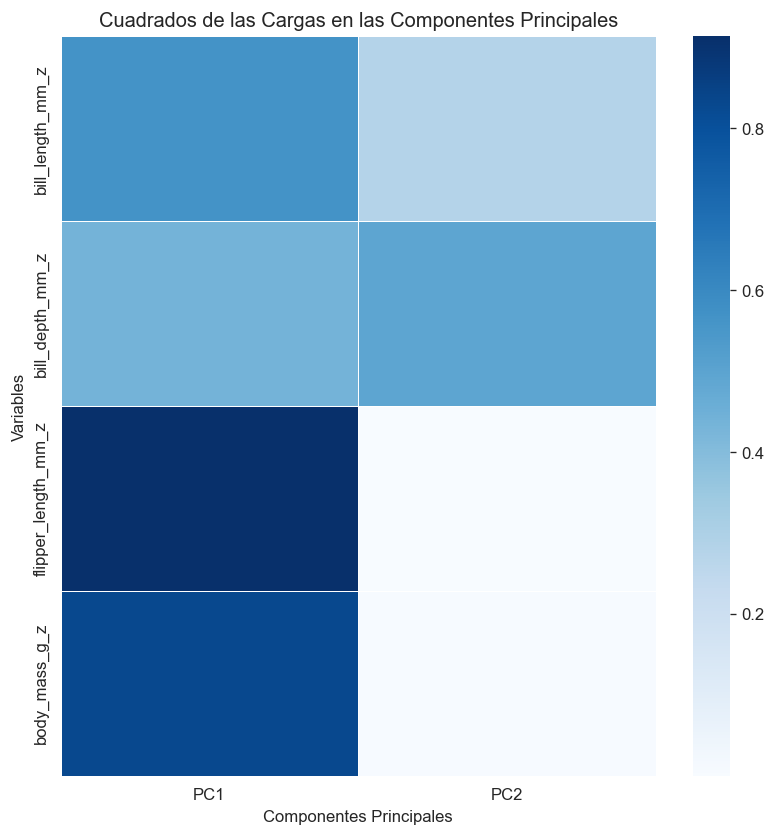

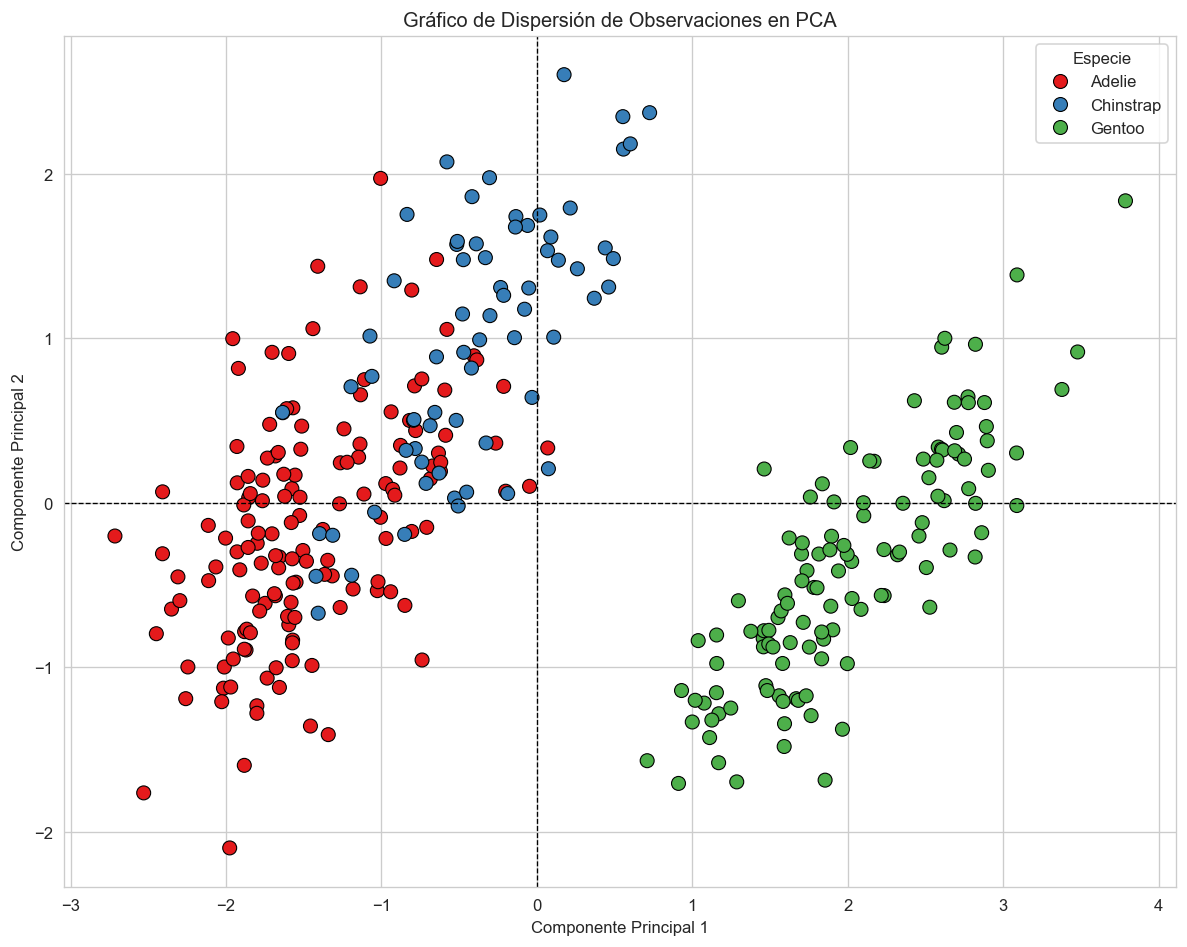

c:\Users\gerso\Desktop\Master Data Science and AI\Modulos\Módulo 8 Mineria de Datos - Clustering\Tarea\FuncionesMineria2.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = cmap(sum_cos2[k])


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

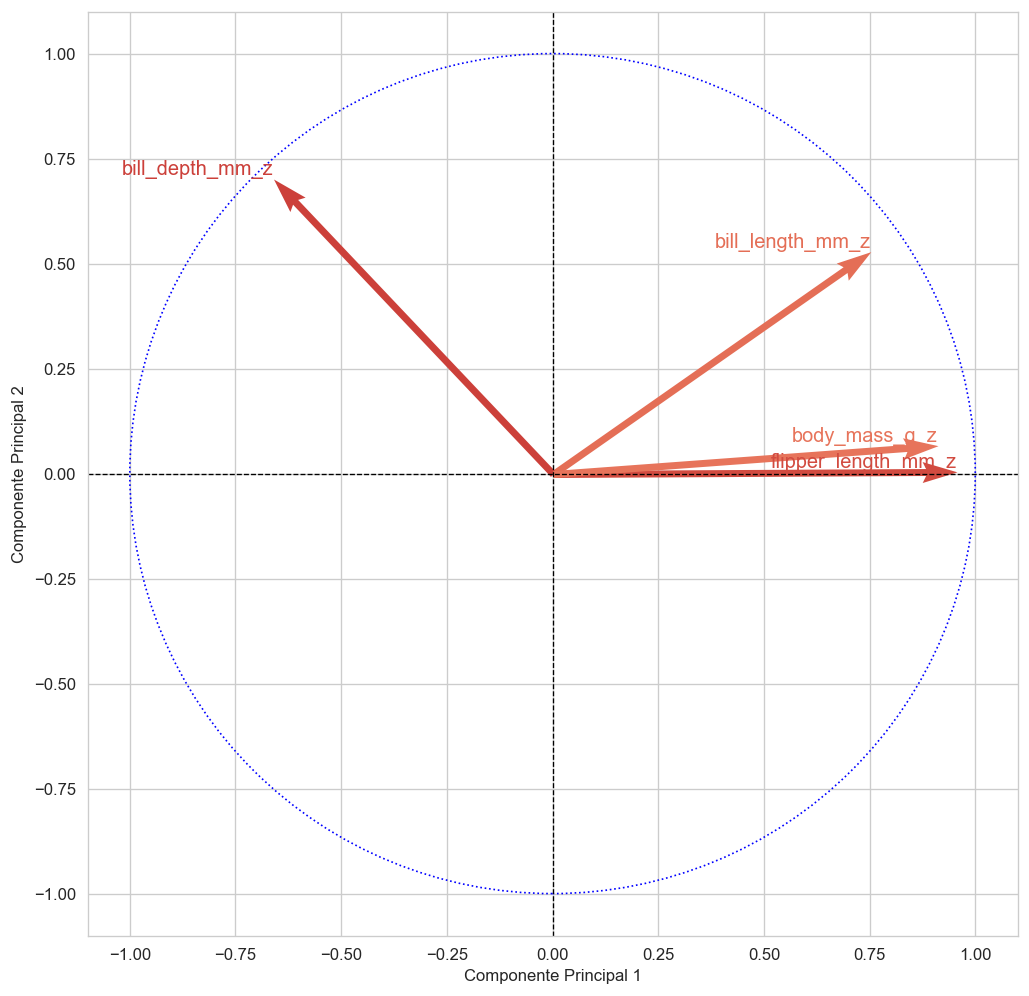

In [7]:
# 1. Ajuste del PCA con 2 componentes sobre los datos estandarizados
pca_opt = PCA(n_components=2)
X_pca = pca_opt.fit_transform(notas_estandarizadas)



# 2. Cálculo de loadings (cargas) de cada variable
df_loadings = pd.DataFrame(
    pca_opt.components_.T,
    index=notas_estandarizadas.columns,
    columns=['PC1', 'PC2']
)
print("Cargas de las variables en PC1 y PC2:\n", df_loadings, "\n")


# 3. Cálculo de scores y medias por especie
df_scores = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df_clean.index)
df_scores['species'] = df_clean['species'].values

species_means = df_scores.groupby('species')[['PC1', 'PC2']].mean()
print("Medias de puntuación por especie:\n", species_means, "\n")


# 4. Heat-map de cos² (contribución al cuadrado)
#    Preparamos la matriz de correlaciones variable–componente
df_components = pd.DataFrame(X_pca, columns=['PC1','PC2'], index=df_scores.index)
corr_full = pd.concat([notas_estandarizadas, df_components], axis=1).corr()
correlaciones = corr_full.loc[notas_estandarizadas.columns, ['PC1','PC2']]
cos2 = correlaciones**2
display(correlaciones)
# Mostrar heat-map de cos²
plot_cos2_heatmap(cos2)

# 5. Componentes
def plot_pca_scatter_colored(df_scores, title="Gráfico de Dispersión de Observaciones en PCA"):
    """
    Muestra un scatter plot de observaciones proyectadas en las dos primeras componentes principales,
    coloreando los puntos según la especie.
    
    Parámetros:
    - df_scores: DataFrame con columnas ['PC1', 'PC2', 'species'].
    """
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_scores,
        x='PC1',
        y='PC2',
        hue='species',
        palette='Set1',  # Puedes cambiar la paleta: 'Set2', 'Set3', 'Dark2', etc.
        edgecolor='black',
        s=70
    )
    plt.axhline(0, linestyle='--', color='black', linewidth=0.8)
    plt.axvline(0, linestyle='--', color='black', linewidth=0.8)
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(title='Especie')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
#Ejecución del gráfico de dispersión con color por especie
plot_pca_scatter_colored(df_scores)

# 6. Círculo de correlaciones
plot_corr_cos(2, correlaciones)





In [ ]:
# Índice morfológico estrictamente positivo basado en PC1
df_scores['Indice_PC1_exp'] = np.exp(df_scores['PC1'])

# Medias del índice por especie
df_scores.groupby('species')['Indice_PC1_exp'].mean()

species
Adelie       0.272915
Chinstrap    0.783538
Gentoo       9.190299
Name: Indice_PC1_exp, dtype: float64

## 7. FASE E – CLUSTERING JERÁRQUICO

En esta fase se aplica un algoritmo de agrupamiento jerárquico al conjunto de datos transformado por PCA. Utilizando la representación reducida en las dos primeras componentes principales, se calcula la matriz de distancias euclídeas entre observaciones y se construye un dendrograma para sugerir un número adecuado de grupos.

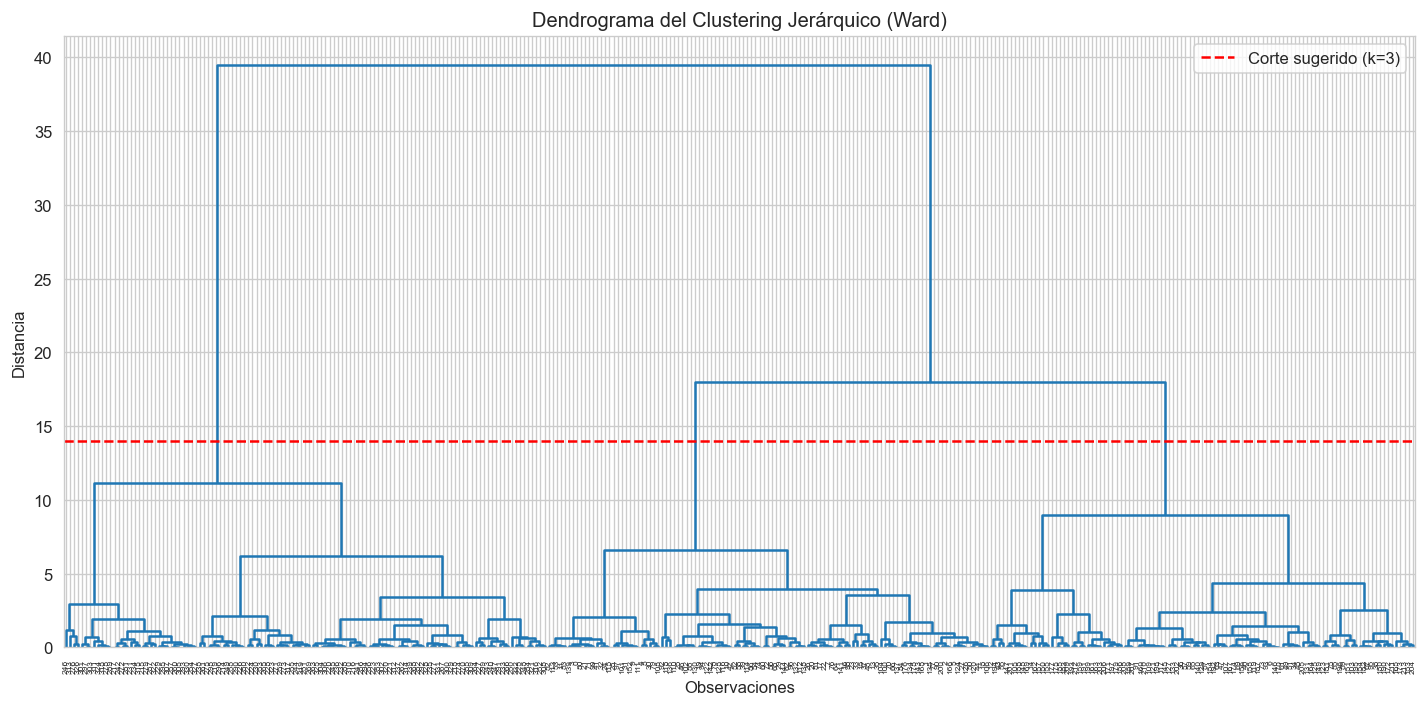

In [13]:
# Usamos solo las componentes PC1 y PC2 para el clustering
X_cluster = df_scores[['PC1', 'PC2']].values

# Cálculo del linkage jerárquico con método 'ward'
Z = linkage(X_cluster, method='ward')

# Dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, color_threshold=0, leaf_rotation=90)
plt.axhline(y=14, color='red', linestyle='--', label='Corte sugerido (k=3)')
plt.title("Dendrograma del Clustering Jerárquico (Ward)")
plt.xlabel("Observaciones")
plt.ylabel("Distancia")
plt.legend()
plt.tight_layout()
plt.show()

## 8. FASE F – K-MEANS Y VALIDACIÓN DEL NÚMERO DE CLÚSTERES

Para validar el número de clústeres sugerido por el análisis jerárquico (k = 3), se aplica el algoritmo de K-means sobre el espacio reducido por PCA. Se evalúan distintos valores de k mediante el gráfico del codo (inercia intra-clúster) y el coeficiente de silueta media.


In [19]:
# Clustering K-means
# Usamos las componentes PC1 y PC2 para el clustering K-means
# Aseguramos que las columnas estén en el orden correcto

X_kmeans = df_scores[['PC1', 'PC2']].values

inertias = []
silhouette_scores = []
ks = range(2, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_kmeans)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_kmeans, labels))


c:\Users\gerso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gerso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gerso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gerso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

El gráfico del codo permite identificar el punto en el que añadir más clústeres deja de reducir significativamente la inercia intra-clúster.


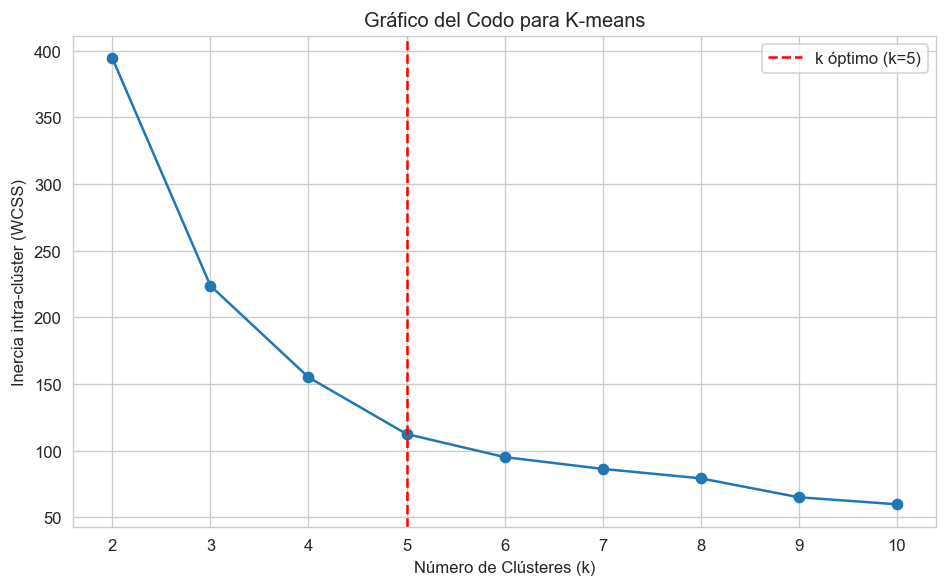

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, marker='o')
plt.xticks(ks)
plt.axvline(x=5, color='red', linestyle='--', label='k óptimo (k=5)')
plt.xlabel("Número de Clústeres (k)")
plt.ylabel("Inercia intra-clúster (WCSS)")
plt.title("Gráfico del Codo para K-means")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



El coeficiente de silueta media mide la cohesión interna y separación entre clústeres. El valor óptimo de k corresponde al máximo de esta medida.


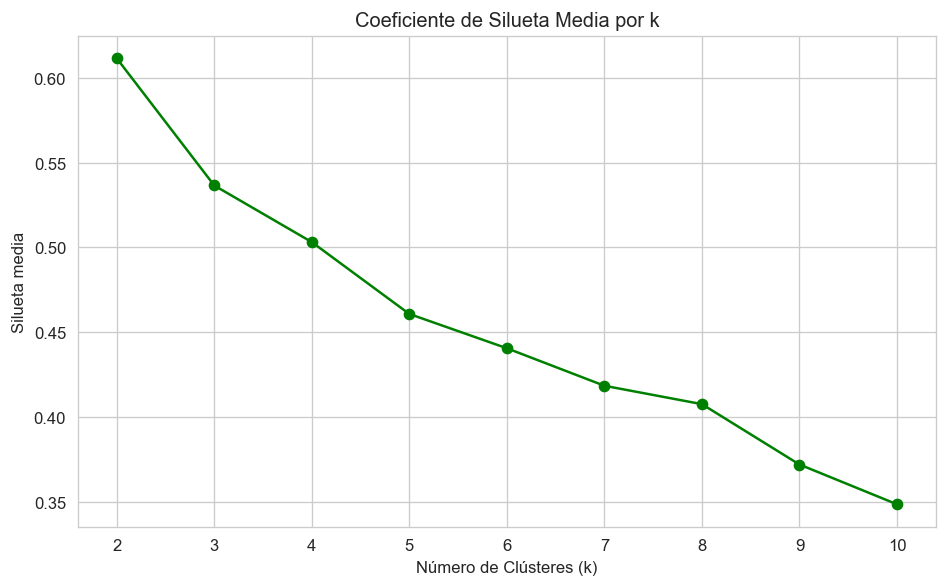

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(ks, silhouette_scores, marker='o', color='green')
plt.xticks(ks)
plt.xlabel("Número de Clústeres (k)")
plt.ylabel("Silueta media")
plt.title("Coeficiente de Silueta Media por k")
plt.grid(True)
plt.tight_layout()
plt.show()


### Aplicación de K-means con k = 5 y visualización de clústeres


c:\Users\gerso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


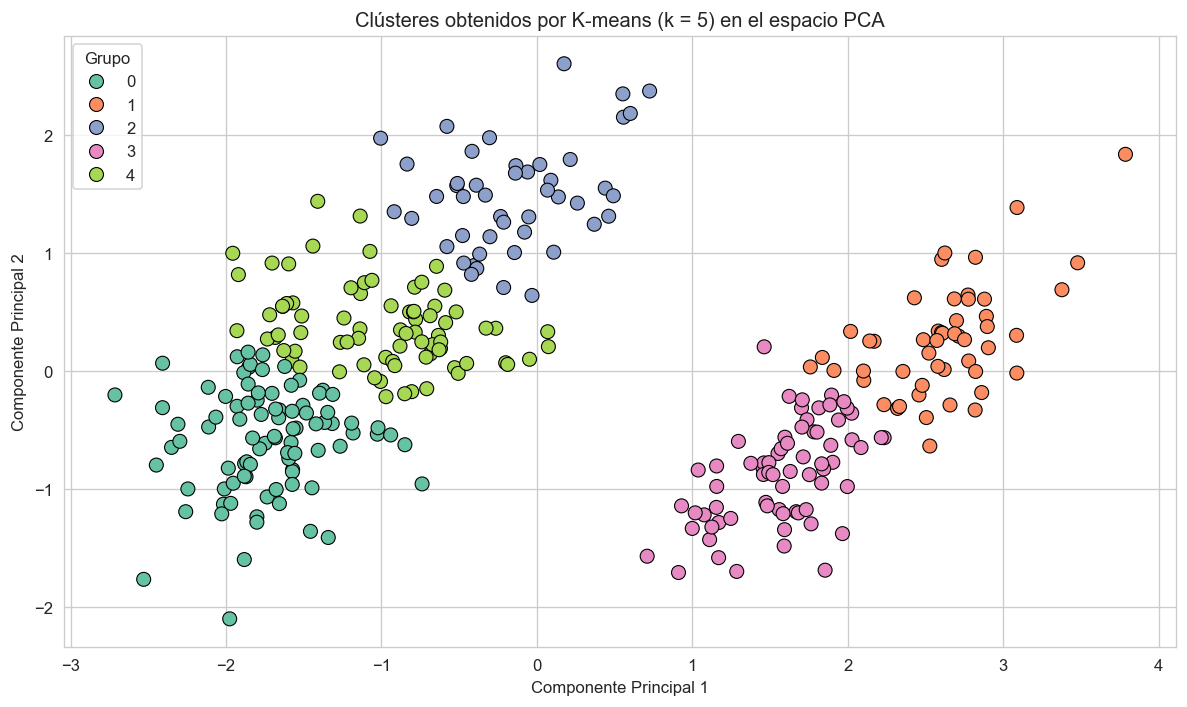

In [27]:
# Aplicar K-means con k = 5
kmeans_5 = KMeans(n_clusters=5, random_state=42)
df_scores['cluster_kmeans_5'] = kmeans_5.fit_predict(df_scores[['PC1', 'PC2']])

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_scores,
    x='PC1',
    y='PC2',
    hue='cluster_kmeans_5',
    palette='Set2',
    s=70,
    edgecolor='black'
)
plt.title("Clústeres obtenidos por K-means (k = 5) en el espacio PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Grupo")
plt.grid(True)
plt.tight_layout()
plt.show()


## 9. FASE G – COMPARACIÓN Y PERFILADO DE GRUPOS

En esta fase se comparan los resultados obtenidos mediante el agrupamiento jerárquico y el algoritmo K-means. Se analiza la correspondencia entre los grupos formados y las especies reales de pingüinos, y se describen los perfiles morfológicos promedio de los grupos definidos por K-means (k = 5).



### 9.1 Comparación entre K-means y especies reales

Se muestra la proporción de especies dentro de cada clúster generado por K-means (k = 5).


In [36]:
# Tabla cruzada normalizada por filas
pd.crosstab(df_scores['cluster_kmeans_5'], df_scores['species'], normalize='index').round(2)



species,Adelie,Chinstrap,Gentoo
cluster_kmeans_5,,,
0,0.94,0.06,0.0
1,0.00,0.00,1.0
2,0.15,0.85,0.0
3,0.00,0.00,1.0
4,0.71,0.29,0.0


### 9.2 Comparación entre agrupamiento jerárquico y K-means

Aunque ambos métodos utilizan el mismo espacio PCA (PC1–PC2), difieren en sus asignaciones. El jerárquico propuso 3 grupos, mientras que el K-means, con k = 5, ofrece una segmentación más detallada que permite explorar subestructuras internas.


A continuación se muestra un resumen estadístico de las variables morfológicas estandarizadas para cada grupo identificado por K-means (k = 5). Se calculan la media y desviación estándar de cada variable, lo que permite caracterizar los perfiles morfológicos de los grupos formados.


### 9.3 Perfil morfológico de los grupos (K-means)

Se calculan las medias y desviaciones estándar de las variables morfológicas estandarizadas para cada grupo generado por K-means.


In [37]:
# Unir variables PCA y morfología estandarizada
df_clustered = df_scores.join(notas_estandarizadas)

# Media y desviación estándar por grupo
group_summary = df_clustered.groupby('cluster_kmeans_5')[[
    'bill_length_mm_z', 'bill_depth_mm_z', 'flipper_length_mm_z', 'body_mass_g_z'
]].agg(['mean', 'std']).round(2)

group_summary


bill_length_mm_z       bill_depth_mm_z        \
                             mean   std            mean   std   
cluster_kmeans_5                                                
0                           -1.17  0.41            0.24  0.46   
1                            1.15  0.43           -0.71  0.38   
2                            1.10  0.59            1.06  0.44   
3                            0.30  0.34           -1.39  0.37   
4                           -0.33  0.59            0.77  0.59   

                 flipper_length_mm_z       body_mass_g_z        
                                mean   std          mean   std  
cluster_kmeans_5                                                
0                              -0.98  0.38         -0.98  0.37  
1                               1.55  0.39          1.67  0.36  
2                              -0.15  0.43         -0.25  0.48  
3                               0.88  0.29          0.69  0.40  
4                              -0.56  0.42         -0.40  0.49

### 9.4 Visualización del perfil de grupos con gráfico radar

El siguiente gráfico radar resume el perfil morfológico promedio de cada clúster de K-means.


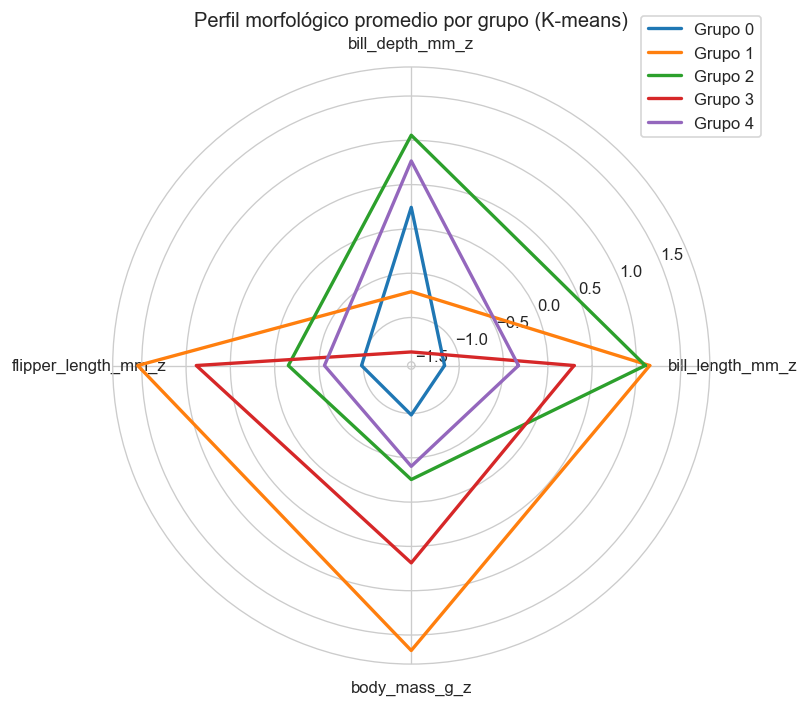

In [39]:
# Variables a graficar
variables = ['bill_length_mm_z', 'bill_depth_mm_z', 'flipper_length_mm_z', 'body_mass_g_z']
group_means = df_clustered.groupby('cluster_kmeans_5')[variables].mean()

# Configuración del radar chart
labels = variables
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # cerrar gráfico

# Crear radar chart
plt.figure(figsize=(8, 6))
for i, row in group_means.iterrows():
    values = row.tolist()
    values += values[:1]  # cerrar forma
    plt.polar(angles, values, label=f'Grupo {i}', linewidth=2)

plt.xticks(angles[:-1], labels)
plt.title("Perfil morfológico promedio por grupo (K-means)")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

## 10. FASE H – CONCLUSIONES Y LIMITACIONES

En esta fase se resumen los hallazgos más relevantes del análisis y se reflexiona sobre las limitaciones metodológicas y técnicas encontradas a lo largo del proceso de agrupamiento no supervisado aplicado al conjunto de datos Palmer Penguins.


### Conclusiones

El análisis ha permitido segmentar el conjunto de pingüinos en grupos morfológicos bien diferenciados, utilizando un enfoque combinado de Análisis de Componentes Principales (ACP) y algoritmos de clustering (jerárquico y K-means).

- El método jerárquico propuso k = 3 como número natural de grupos, lo cual coincide con la clasificación taxonómica en tres especies.
- El algoritmo K-means, validado mediante el gráfico del codo y el coeficiente de silueta, permitió adoptar k = 5 como solución óptima, revelando subestructuras internas y zonas de transición morfológica.

Entre los hallazgos más destacados se encuentra el grupo 4 de K-means, que representa una mezcla intermedia entre Adelie y Chinstrap. Este grupo plantea la posibilidad de una población híbrida o una diferenciación evolutiva incipiente, hipótesis que puede ser explorada en estudios genéticos futuros.

El enfoque basado en ACP + clustering ha resultado eficaz para sintetizar información multivariada y descubrir patrones no evidentes, proporcionando una base sólida para análisis ecológicos y evolutivos.


### Limitaciones y desafíos

Durante el desarrollo del análisis se presentaron algunas limitaciones y consideraciones metodológicas relevantes:

- El número de clústeres en K-means debe definirse a priori, lo cual introduce subjetividad en la interpretación del gráfico del codo.
- El algoritmo K-means asume agrupamientos esféricos y de varianza similar, lo que puede no ajustarse a la distribución real de los datos.
- El ACP, si bien útil para reducir dimensiones, puede perder información estructural de variables no incluidas o relaciones no lineales.
- La validación de los grupos identificados se limita a medidas internas como WCSS y silueta; no se dispone de una validación externa directa salvo las especies, que no siempre coinciden con las estructuras descubiertas.

A pesar de estas limitaciones, los resultados obtenidos ofrecen una segmentación coherente y útil para caracterizar la diversidad morfológica de los pingüinos del conjunto de datos analizado.
